In [ ]:
# Check GPU
!nvidia-smi

# Install required packages
!pip install timm einops torchsummary

Fri Oct  3 11:54:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

🚀 Using device: cuda
   GPU: Tesla T4
📊 Train samples: 50000, Test samples: 10000
🔧 Loading pretrained ViT-B/16...


/tmp/ipython-input-2101394293.py:152: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CFG["use_amp"])


   ✓ Loaded with IMAGENET1K_V1 weights
📊 Trainable parameters: 21,271,306 / 85,806,346 (24.79%)
📊 Unfrozen layers: 3/12

🎯 Starting training...



Epoch 1/7 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2101394293.py:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG["use_amp"]):
[Eval]:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-2101394293.py:211: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG["use_amp"]):
[Eval]: 100%|██████████| 79/79 [00:28<00:00,  2.77it/s]



📈 Epoch 1/7:
   Train Loss: 0.8020 | Train Acc: 88.42%
   Test Acc: 95.95% | LR: 3.33e-05
   ✅ New best model saved! Test Acc: 95.95%



[Eval]: 100%|██████████| 79/79 [00:28<00:00,  2.80it/s]



📈 Epoch 2/7:
   Train Loss: 0.6638 | Train Acc: 93.21%
   Test Acc: 96.62% | LR: 6.67e-05
   ✅ New best model saved! Test Acc: 96.62%



[Eval]: 100%|██████████| 79/79 [00:28<00:00,  2.75it/s]



📈 Epoch 3/7:
   Train Loss: 0.6361 | Train Acc: 94.33%
   Test Acc: 96.67% | LR: 1.00e-04
   ✅ New best model saved! Test Acc: 96.67%



[Eval]: 100%|██████████| 79/79 [00:28<00:00,  2.80it/s]



📈 Epoch 4/7:
   Train Loss: 0.6119 | Train Acc: 95.23%
   Test Acc: 96.97% | LR: 1.00e-04
   ✅ New best model saved! Test Acc: 96.97%



[Eval]: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]



📈 Epoch 5/7:
   Train Loss: 0.5946 | Train Acc: 96.03%
   Test Acc: 97.07% | LR: 8.54e-05
   ✅ New best model saved! Test Acc: 97.07%



[Eval]: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]



📈 Epoch 6/7:
   Train Loss: 0.5768 | Train Acc: 96.71%
   Test Acc: 97.25% | LR: 5.00e-05
   ✅ New best model saved! Test Acc: 97.25%



[Eval]: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]



📈 Epoch 7/7:
   Train Loss: 0.5623 | Train Acc: 97.39%
   Test Acc: 97.28% | LR: 1.46e-05
   ✅ New best model saved! Test Acc: 97.28%


🎯 FINAL BEST TEST ACCURACY: 97.28%



[Eval]: 100%|██████████| 79/79 [00:30<00:00,  2.62it/s]


📊 Confusion matrix saved to 'confusion_matrix.png'
📈 Training curves saved to 'training_curves.png'

📊 Per-Class Accuracy:
----------------------------------------
airplane    :  98.20% (982/1000)
automobile  :  99.40% (994/1000)
bird        :  96.00% (960/1000)
cat         :  93.60% (936/1000)
deer        :  97.30% (973/1000)
dog         :  96.70% (967/1000)
frog        :  99.00% (990/1000)
horse       :  97.20% (972/1000)
ship        :  98.10% (981/1000)
truck       :  97.30% (973/1000)
----------------------------------------

✅ Training complete!
💾 Model saved as: best_vit_b16_cifar10.pth


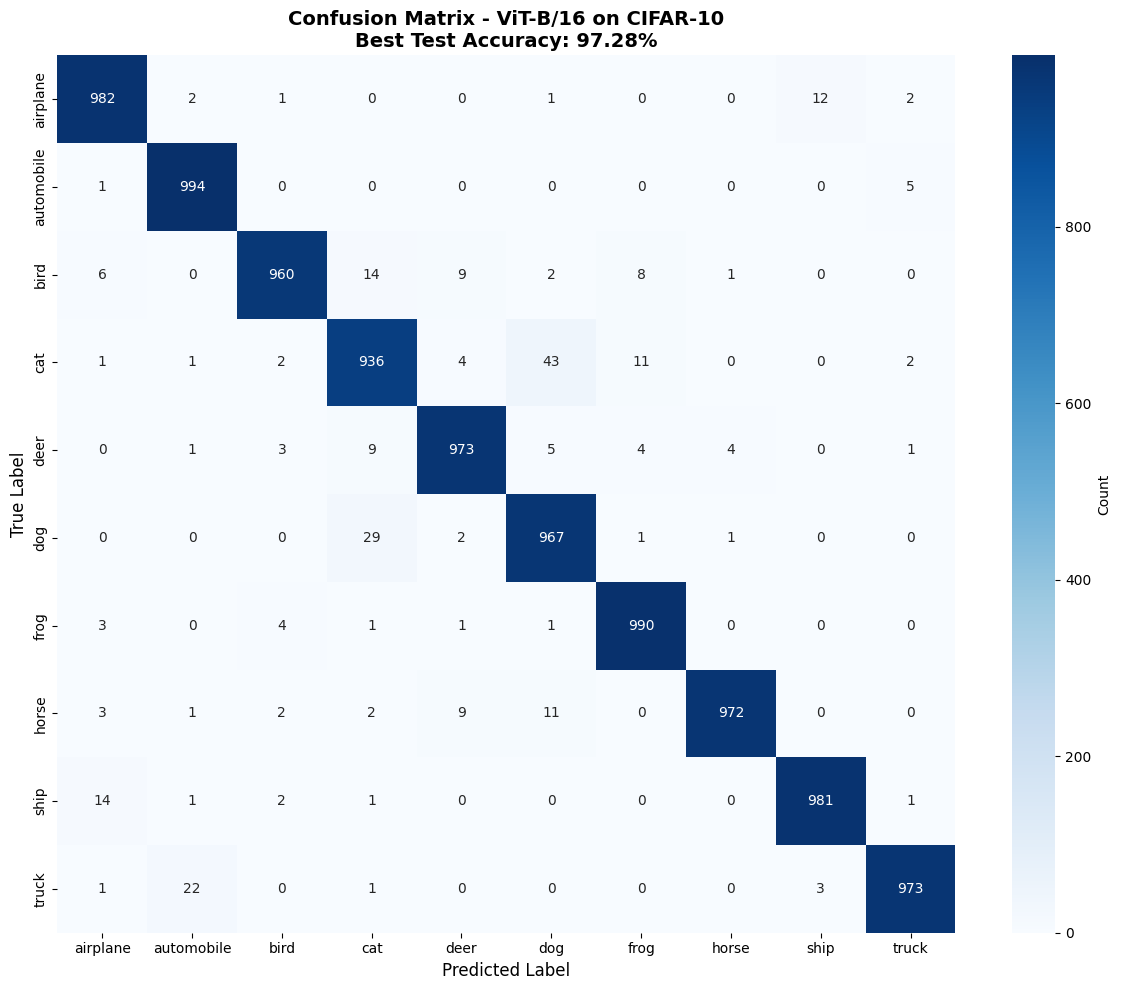

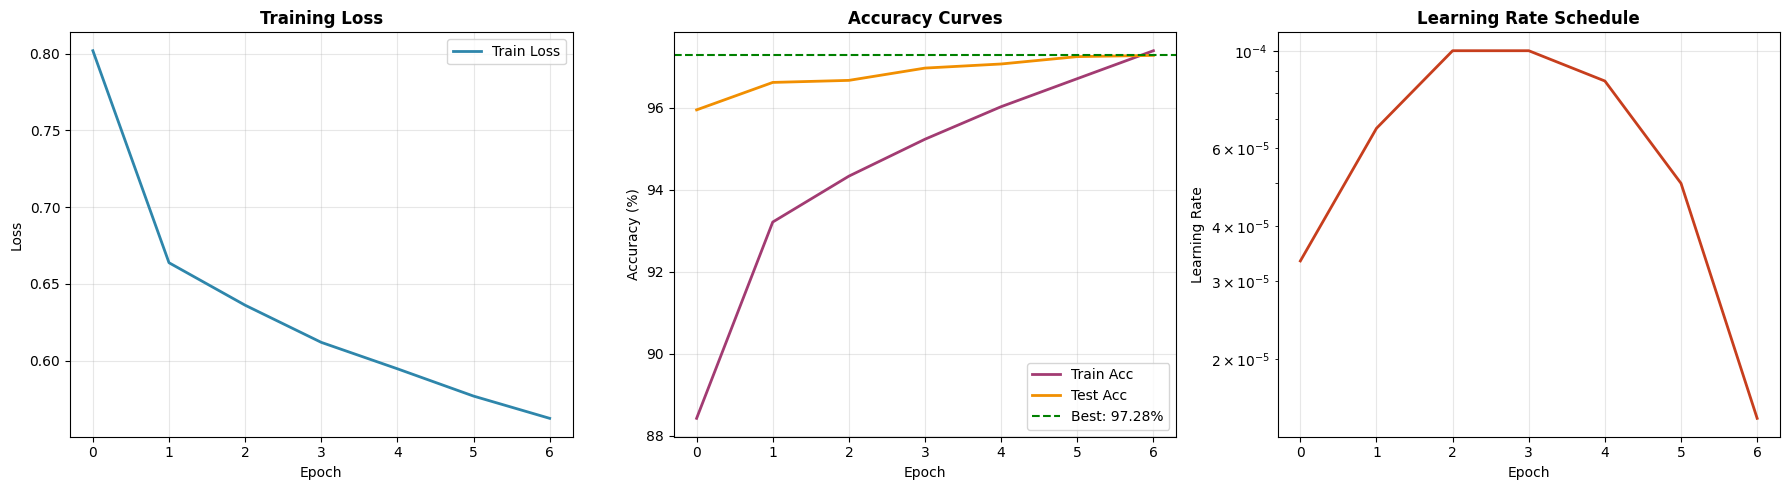

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# 1️ OPTIMIZED CONFIGURATION
# ============================================
CFG = {
    "epochs": 7,
    "batch_size": 128,
    "lr": 1e-4,
    "weight_decay": 0.01,
    "num_workers": 4,
    "pin_memory": True,
    "seed": 42,
    "use_amp": True,
    "grad_clip": 1.0,
    "patience": 7,
    "label_smoothing": 0.1,
    "warmup_epochs": 3,
    "min_lr": 1e-7,
}

# ============================================
# 2️ DEVICE & REPRODUCIBILITY
# ============================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])
if device == "cuda":
    torch.cuda.manual_seed_all(CFG["seed"])
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# ============================================
# 3️ ADVANCED DATA AUGMENTATION
# ============================================
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=28, padding_mode='reflect'),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.33))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# ============================================
# 4️ DATASET & DATALOADERS
# ============================================
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

trainloader = DataLoader(
    train_dataset,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=CFG["pin_memory"],
    persistent_workers=True if CFG["num_workers"] > 0 else False
)
testloader = DataLoader(
    test_dataset,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=CFG["pin_memory"],
    persistent_workers=True if CFG["num_workers"] > 0 else False
)

print(f"📊 Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ============================================
# 5️ MODEL: PRETRAINED ViT-B/16
# ============================================
print("🔧 Loading pretrained ViT-B/16...")

# Loadign with proper weights
try:
    # Trying new API first
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)
    print("   ✓ Loaded with IMAGENET1K_V1 weights")
except:
    # Fallback
    try:
        model = vit_b_16(weights='DEFAULT')
        print("   ✓ Loaded with DEFAULT weights")
    except:
        model = vit_b_16(pretrained=True)
        print("   ✓ Loaded with pretrained=True")

# Replacing classification head for CIFAR-10 (10 classes)
in_features = model.heads.head.in_features
model.heads = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, 10)
)

# Strategy: Unfreezing last 3 transformer blocks + head for ViT-B/16
for param in model.parameters():
    param.requires_grad = False

# ViT-B/16 has 12 encoder layers, unfreezing last 3
num_layers = len(model.encoder.layers)
unfreeze_layers = 3
for param in model.encoder.layers[-unfreeze_layers:].parameters():
    param.requires_grad = True

# Unfreeze classification head
for param in model.heads.parameters():
    param.requires_grad = True

model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"📊 Unfrozen layers: {unfreeze_layers}/{num_layers}")

# ============================================
# 6️ OPTIMIZER, LOSS, SCHEDULER
# ============================================
criterion = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])
optimizer = optim.AdamW(
    model.parameters(),
    lr=CFG["lr"],
    weight_decay=CFG["weight_decay"],
    betas=(0.9, 0.999)
)
scaler = torch.cuda.amp.GradScaler(enabled=CFG["use_amp"])

# Cosine annealing with warmup
def get_cosine_schedule_with_warmup(optimizer, warmup_epochs, total_epochs, min_lr=CFG["min_lr"]):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return max(min_lr / CFG["lr"], 0.5 * (1.0 + np.cos(np.pi * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_schedule_with_warmup(optimizer, CFG["warmup_epochs"], CFG["epochs"])

# ============================================
# 7️ TRAINING & EVALUATION
# ============================================
def train_epoch(epoch):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0

    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CFG['epochs']} [Train]")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=CFG["use_amp"]):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        if CFG["grad_clip"] > 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })

    return loss_sum / len(trainloader), 100.*correct/total

def evaluate():
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(testloader, desc="[Eval]"):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=CFG["use_amp"]):
                outputs = model(imgs)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return 100.*correct/total, np.array(all_preds), np.array(all_labels)

# ============================================
# 8️ TRAINING LOOP WITH EARLY STOPPING
# ============================================
print("\n🎯 Starting training...\n")
best_acc, patience_counter = 0.0, 0
history = {'train_loss': [], 'train_acc': [], 'test_acc': [], 'lr': []}

for epoch in range(CFG["epochs"]):
    train_loss, train_acc = train_epoch(epoch)
    test_acc, preds, labels = evaluate()
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)

    print(f"\n📈 Epoch {epoch+1}/{CFG['epochs']}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Test Acc: {test_acc:.2f}% | LR: {current_lr:.2e}")

    if test_acc > best_acc:
        best_acc = test_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'config': CFG
        }, "best_vit_b16_cifar10.pth")
        print(f"   ✅ New best model saved! Test Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement ({patience_counter}/{CFG['patience']})")

    if patience_counter >= CFG["patience"]:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
        break
    print()

print(f"\n{'='*60}")
print(f"🎯 FINAL BEST TEST ACCURACY: {best_acc:.2f}%")
print(f"{'='*60}\n")

# ============================================
# 9️⃣ VISUALIZATIONS
# ============================================
# Load best model for final evaluation
checkpoint = torch.load("best_vit_b16_cifar10.pth")
model.load_state_dict(checkpoint['model_state_dict'])
final_acc, final_preds, final_labels = evaluate()

# Confusion Matrix
cm = confusion_matrix(final_labels, final_preds)
class_names = train_dataset.classes

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - ViT-B/16 on CIFAR-10\nBest Test Accuracy: {best_acc:.2f}%',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("📊 Confusion matrix saved to 'confusion_matrix.png'")

# Training Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curve
axes[0].plot(history['train_loss'], linewidth=2, color='#2E86AB', label='Train Loss')
axes[0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Accuracy curves
axes[1].plot(history['train_acc'], linewidth=2, color='#A23B72', label='Train Acc')
axes[1].plot(history['test_acc'], linewidth=2, color='#F18F01', label='Test Acc')
axes[1].axhline(y=best_acc, color='green', linestyle='--', linewidth=1.5, label=f'Best: {best_acc:.2f}%')
axes[1].set_title('Accuracy Curves', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Learning rate schedule
axes[2].plot(history['lr'], linewidth=2, color='#C73E1D')
axes[2].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("📈 Training curves saved to 'training_curves.png'")

# Per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10
for pred, true in zip(final_preds, final_labels):
    class_total[true] += 1
    if pred == true:
        class_correct[true] += 1

print("\n📊 Per-Class Accuracy:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{class_name:12s}: {acc:6.2f}% ({class_correct[i]}/{class_total[i]})")
print("-" * 40)

print("\n✅ Training complete!")
print(f"💾 Model saved as: best_vit_b16_cifar10.pth")